<a href="https://colab.research.google.com/github/alecmucz/CompVision/blob/master/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 3

###### Imports and Load Frame

In [41]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import io as io_url

In [42]:
frame = np.float32(io_url.imread('https://raw.githubusercontent.com/alecmucz/CompVision/master/cameraman.jpg'))/255

###### Harris Corner Detector

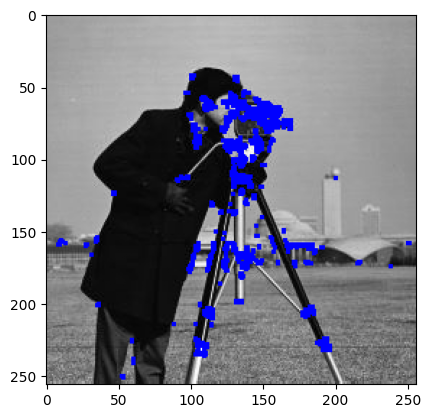

In [43]:
frame_copy0 = np.copy(frame)

# Grayscale
gray_copy0 = cv2.cvtColor(frame_copy0, cv2.COLOR_BGR2GRAY)

# Sobel Gradients
sobelx = cv2.Sobel(gray_copy0, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray_copy0, cv2.CV_64F, 0, 1, ksize=5)
laplacian = cv2.Laplacian(gray_copy0, cv2.CV_32F)

# Harris Corner Detector
harris = cv2.cornerHarris(gray_copy0,blockSize=2,ksize=3,k=0.04)
harris = cv2.dilate(harris, None)
frame_copy0[harris > 0.01 * harris.max()] = [0, 0, 255]

plt.imshow(frame_copy0)

###### Scale Invariance

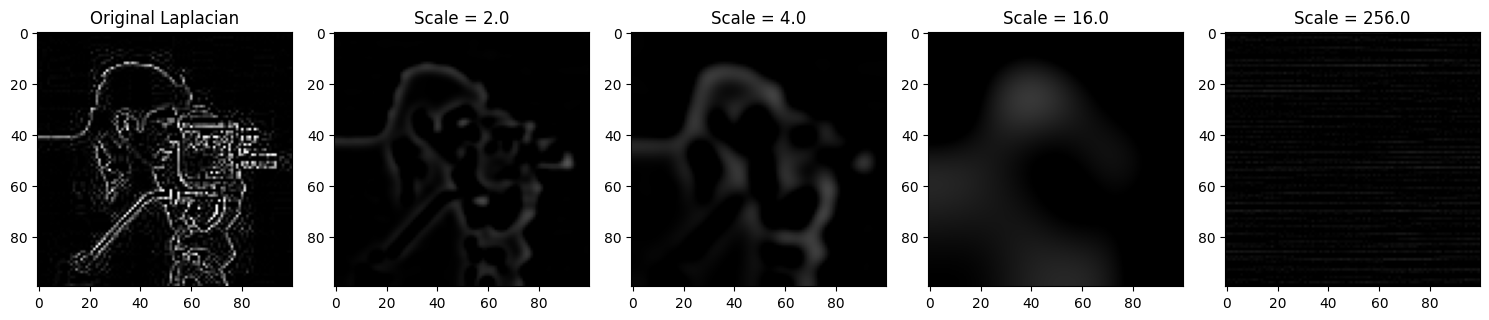

In [44]:
frame_copy1 = np.copy(frame[25:125, 75:175, :])

laplacian = cv2.Laplacian(frame_copy1, cv2.CV_32F)

_,axes = plt.subplots(1, 5, figsize=(15, 3))

axes[0].imshow(laplacian, cmap='gray')
axes[0].set_title('Original Laplacian')

scale = 2.0
for i in range(4):
    blurred_copy1 = cv2.GaussianBlur(frame_copy1, (0,0), sigmaX=scale)
    laplacian_scaled = cv2.Laplacian(blurred_copy1, cv2.CV_32F)
    normalized_laplacian = laplacian_scaled * (scale ** 2)

    axes[i+1].imshow(normalized_laplacian, cmap='gray')
    axes[i+1].set_title(f'Scale = {scale:.1f}')

    scale = (scale ** 2)

plt.tight_layout()
plt.show()


###### Image Alignment using RANSAC

In [69]:
cameraMan = np.copy(frame)
gray_cameraMan = np.uint8(np.copy(gray_copy0))
lap_cameraMan = np.copy(laplacian)
gray_laplacian = np.uint8(cv2.cvtColor(lap_cameraMan, cv2.COLOR_BGR2GRAY))

orb = cv2.ORB_create(nfeatures=1000)

cameraMan_keyPoints , des1 = orb.detectAndCompute(gray_cameraMan,None)
lap_keyPoints , des2 = orb.detectAndCompute(gray_laplacian, None)

bf = cv2.BFMatcher_create()

matches = bf.match(des1, des2)

src_pts = np.float32([cameraMan_keyPoints[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([lap_keyPoints[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

harm_matrix, mark = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

alignedImg = cv2.warpPerspective(cameraMan, harm_matrix, (lap_cameraMan.shape[1], lap_cameraMan.shape[0]))
plt.imshow(alignedImg)

error: OpenCV(4.11.0) /io/opencv/modules/calib3d/src/fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'
